### Imports et données

In [359]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import preprocessing, decomposition, cluster, metrics
from statsmodels.compat import lzip
from math import sqrt
from scipy.stats import shapiro, skew

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt

In [360]:
billets = pd.read_csv('./billets.csv', sep=';')

# Exploration des données

On commence par explorer grossièrement nos données pour nous rendre compte de la forme et des potentiels problèmes qu'il faudrait corriger.

In [361]:
billets.shape

(1500, 7)

On regarde la forme global de notre dataset. On voit ici qu'il contient 1500 lignes et 7 colonnes.

In [362]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


Avec cette fonction on peut voir les 5 premières lignes, ce qui nous permet de nous faire une idée des variables et d'en apprendre un peu plus sur nos données.

In [363]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


Ici on peut voir le nom des colonnes, leurs types et enfin le nombre de valeurs non null. On se rend donc compte qu'il manque des valeurs dans la colonne margin_low.

In [364]:
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Enfin on peut voir, grâce à cette dernière fonction, différents quantiles, la moyenne, etc... Cela nous permet de voir si des valeurs sont abérantes par exemple.
Grâce à cette rapide exploration des données, on peut voir qu'il manque des données dans la colonne margin_low. Il va donc falloir les estimer.

Ensuite on réalise un pairplot qui peut nous permettre de trouver des liens entres les variables.

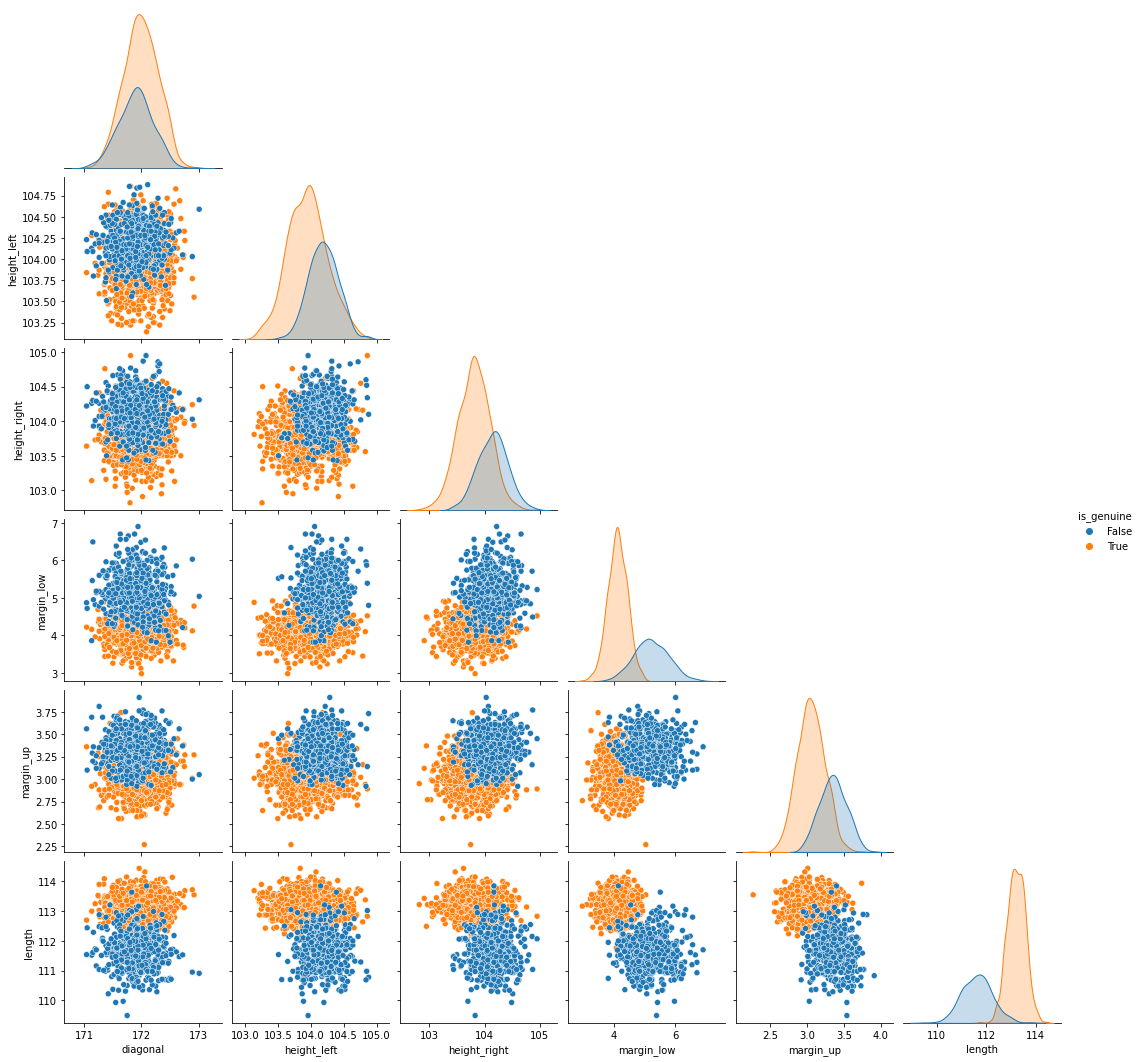

In [365]:
sns.pairplot(billets, hue='is_genuine', corner=True)

Après avoir coloré les points en fonction de la valeur is_genuine qui indique la véracité ou non d'un billet on voit deja des groupes se former. Ainsi on peut se rendre compte des variables qui seront les plus importantes pour prédire la véracité de nos billets.

Par exemple la distribution de la variable diagonal est la même pour les vrais et faux billets, on peut conclure que cette variable ne nous sera pas ou peu utile. Par contre pour les variables length et margin_low semblent pouvoir être très utile car on voit clairement que les distributions sont différentes entre vrais et faux billets. D'ailleurs lorsqu'on regarde le nuage de point entre ces deux variables on voit deux groupes assez distinct.

Nous créons une matrice de correlation qui nous permettra de comparer nos billets entre eux

<AxesSubplot:>

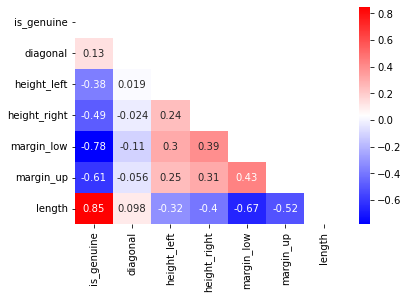

In [366]:
### Matrice de corélation

data = billets.corr()
matrix = np.triu(data)

sns.heatmap(data, cmap="bwr", annot=True, mask=matrix)

Enfin grâce à cette matrice on peut voir les liens entre les variables. Ici on peut voir que is_genuine est fortement corrélé aux variables length et margin_low, ce qui rejoint ce qu'on a déjà observé.

## Analyse en composante principale

On réalise une ACP pour résumé les données et pour se rendre compte si il y a deux groupes qui se forment.

In [367]:
df = billets.drop('is_genuine', axis=1).loc[billets['margin_low'].notnull()]
df

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...
1495,171.75,104.38,104.17,4.42,3.09,111.28
1496,172.19,104.63,104.44,5.27,3.37,110.97
1497,171.80,104.01,104.12,5.51,3.36,111.95
1498,172.06,104.28,104.06,5.17,3.46,112.25


Pour notre ACP il nous faut uniquement des données complètes. Je retire donc les données pour lesquelles la valeur de margin_low n'est pas présente.

In [368]:
X = df.values

std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

pca = decomposition.PCA()
pca.fit(X_scaled)

PCA()

On entraine notre algorithme sur le jeu de données.

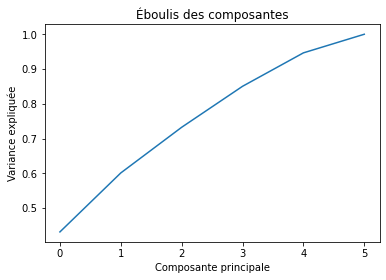

In [369]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title('Éboulis des composantes')
plt.xlabel('Composante principale')
plt.ylabel('Variance expliquée')
plt.show()

Et enfin on réalise l'éboulis des composantes qui va nous permettre d'évaluer le nombre optimal de composante principale. Par exemple ici avec la premère composante on explique environ 40% des données, avec deux environ 60%, etc... Ici nous choisirons seulement les deux premières composantes car ce qui nous interesse est principalement visuel.

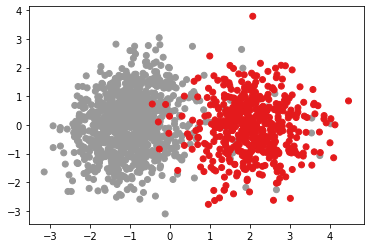

In [370]:
# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)
data = pd.DataFrame(X_projected)
X_projected = data.values

data['is_genuine'] = billets['is_genuine'].astype(int)

# afficher chaque observation
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=data['is_genuine'], cmap='Set1')

On projète donc nos données sur les deux premieres composantes et on voit bien se dessiner deux groupes. En plus on colore nos point en fonction de si il représente un vrai ou un faux billets. On voit donc assez bien deux groupes se créer.

(-1.0, 1.0)

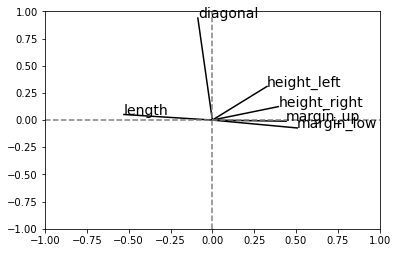

In [371]:
pcs = pca.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, df.columns[i], fontsize='14')

# Afficher une ligne horizontale y=0
plt.plot([-1, 1], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

plt.xlim([-1, 1])
plt.ylim([-1, 1])

Grâce à ce graphique on peut commencer à caractériser nos données. Par exemple on voit que la variable diagonal nous renseigne assez mal sur le cluster auquel appartient le billet par contre les autres variables semblent toutes utiles.

# Estimation des données manquantes par régression linéaire

Maintenant on veut estimer les valeurs manquantes grâce à une régression linéaire. On commence par évaluer notre modèle de régression linéaire par validation croisée.

In [372]:
# Lib : sklearn

# billets_train = billets.loc[~billets['margin_low'].isnull()]

# true = []
# pred = []
# folds = KFold(n_splits=5, shuffle=True).split(billets_train)
# for train, test in folds:
#     x = billets_train.iloc[train].drop('margin_low', axis=1)
#     y = billets_train.iloc[train]['margin_low']
#     model_linRegMul = LinearRegression()
#     model_linRegMul.fit(x, y)
#     pred.append(model_linRegMul.predict(billets_train.iloc[test].drop('margin_low', axis=1)))
#     true.append(billets_train.iloc[test]['margin_low'])
# true = np.concatenate(true)
# pred = np.concatenate(pred)

In [373]:
# Lib : statsmodel

billets_train = billets.loc[~billets['margin_low'].isnull()]

true = []
pred = []
folds = KFold(n_splits=5, shuffle=True).split(billets_train)
for train, test in folds:
    reg_multi = smf.ols('margin_low ~ is_genuine+diagonal+height_left+height_right+margin_up+length', data=billets_train.iloc[train]).fit()
    pred.append(reg_multi.predict(billets_train.iloc[test]))
    true.append(billets_train.iloc[test]['margin_low'])
true = np.concatenate(true)
pred = np.concatenate(pred)

Ici nous testons notre algorithme sur les données de tests. Pour ce faire on sépare le jeu de données en 5 et on prédis un des split grâce aux quatres autres. Cela nous permet de prédire toutes les données disponibles et de nous rendre compte de l'efficacité de l'algorithme.

In [374]:
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     312.6
Date:                Sat, 18 Mar 2023   Prob (F-statistic):          1.49e-238
Time:                        15:40:58   Log-Likelihood:                -608.28
No. Observations:                1171   AIC:                             1231.
Df Residuals:                    1164   BIC:                             1266.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.6848      9

Le summary nous donne quelques informations importante sur la régression multiple comme ses coeficiants, son R^2, etc... On recalculera certaine de ces valeurs car ici le summary ne nous donne que les valeurs pour un des splits.

In [375]:
print('R2: %f' % r2_score(true, pred))

R2: 0.611816


Le coefficient de détermination nous permet de dire que notre modèle est assez performant.

In [376]:
mse = mean_squared_error(true, pred)
rmse = sqrt(mse)
print('MSE: %f' % mse)
print('RMSE: %f' % rmse)

MSE: 0.170935
RMSE: 0.413443


L'erreur quadratique est faible. Cela signifie que notre modèle induit une faible marge d'erreur.

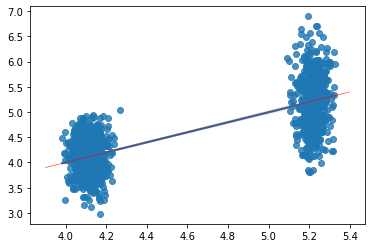

In [377]:
sns.regplot(x=pred, y=true)
plt.plot([3.9, 5.4], [3.9, 5.4], 'r-', lw=.5)

Ce nuage de point prend en coordonnées les valeurs prédites et les valeurs réalles, cela nous permet d'évaluer visuellement la qualité de nos prédiction qui semblent assez bien regroupé autour de la droite de régression, donc les prédictions semblent cohérentes.

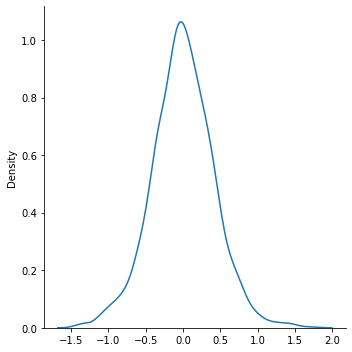

In [378]:
residu = true - pred

sns.displot(residu, kind="kde")

Ici nous analysons la normalité des résidus. Il semble que les résidus suivent une loi normale donc notre modèle est bon.

In [379]:
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9954855442047119, pvalue=0.0015073902904987335)

In [380]:
skew(residu)

0.06114245888817651

La p-value du test de shapiro est inférieur à 0,05 donc on rejète l'hypothèse d'indépendance et il est peu probable d'obtenir de telles données en supposant qu'elles soient normalement distribuées. Il semblerait qu'il manque une ou deux valeurs significative ou qu'il y ai des outliers.
Par contre le skewness est assez faible donc la répartition des résidus est symétrique.

In [381]:
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(reg_multi.resid, reg_multi.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', 134.3576366664727),
 ('p-value', 1.5522878593110565e-26),
 ('f-value', 25.14404430615525),
 ('f p-value', 3.6132115542344477e-28)]

Ce test permet de tester l'homoscédasticité c'est-à-dire de voir si la variance de ses erreurs est constante. la p-value est inférieur à 0,05 il est donc peu probable d'obtenir de telles données en supposant qu'on ai de l'homoscédasticité. Il semble qu'il manque une ou deux variables représentatives.

In [382]:
billets_train.insert(0, 'residus', residu)

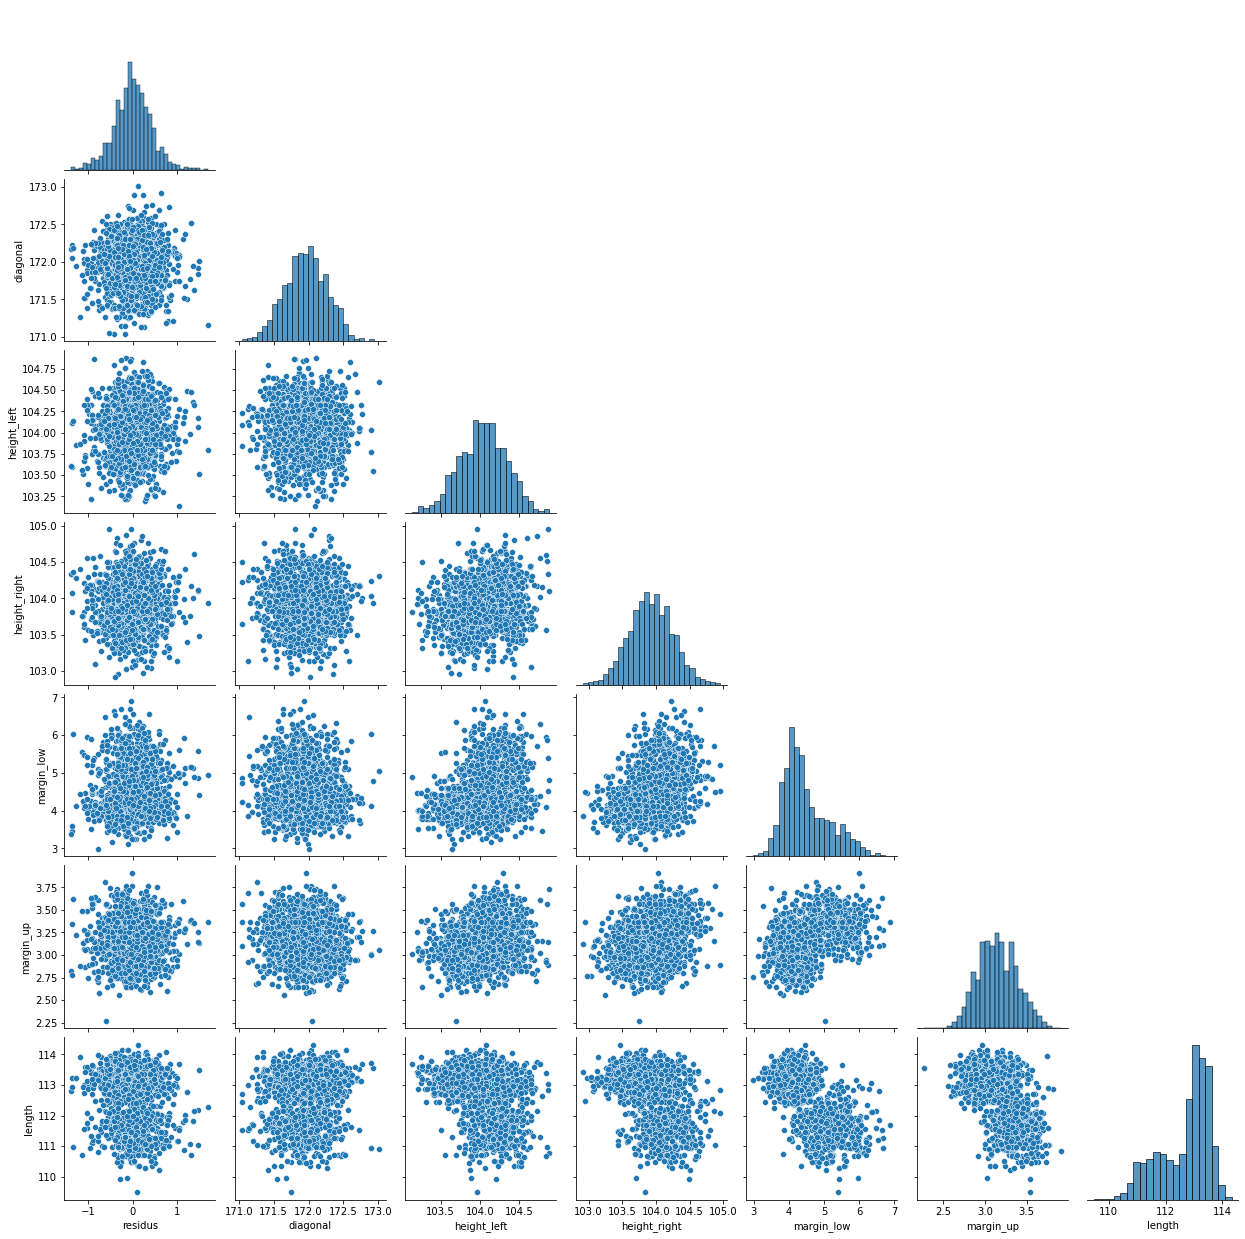

In [383]:
sns.pairplot(billets_train.drop('is_genuine', axis=1), corner=True)

Visuellement, il ne semble pas qu'il y ai d'hétéroscédasticité soit que l'erreurs qoit corrélé à une variable. De plus il semble que visuellement les résidus suivent une loi normale.

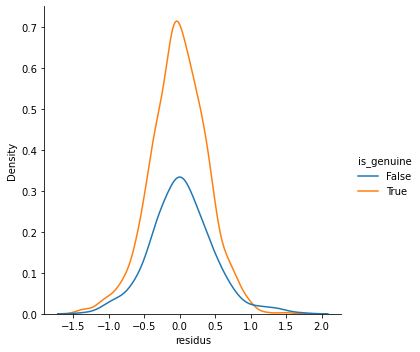

In [384]:
sns.displot(data=billets_train, x='residus', hue='is_genuine', kind='kde')

Notre modèle semble visuellement correct mais il est améliorable en ajoutant une ou deux variables significatives ou en supprimant les outliers.
On continuera avec ce modèle.

In [385]:
# Lib : sklearn

# x = billets_train.drop('margin_low', axis=1)
# y = billets_train['margin_low']
# model_linRegMul = LinearRegression()
# model_linRegMul.fit(x, y)

In [386]:
# Lib : statsmodel

reg_multi = smf.ols('margin_low ~ is_genuine+diagonal+height_left+height_right+margin_up+length', data=billets).fit()

In [387]:
print(reg_multi.summary())
#print(model_linRegMul.coef_)

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Sat, 18 Mar 2023   Prob (F-statistic):          4.75e-299
Time:                        15:41:05   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.8668      8

On entraine notre modèle sur l'ensemble de nos données.

In [388]:
# Lib : statsmodels

billets_test = billets.loc[billets['margin_low'].isnull()]
prediction = reg_multi.predict(billets_test)

for i in prediction.index:
  billets.loc[i, 'margin_low'] = prediction[i]

In [389]:
# Lib : sklearn

# billets_test = billets.loc[billets['margin_low'].isnull()].drop('margin_low', axis=1)
# prediction = model_linRegMul.predict(billets_test)
# tab = pd.DataFrame(prediction, index = billets_test.index)

# for i in tab.index:
#   billets.at[i, 'margin_low'] = tab.loc[i]

Et on prédit la valeur de margin_low pour les billets concernés.

In [390]:
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.482844,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659899,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.027500,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


On voit que maintenant nos données sont complètes on peut donc passer à la suite.

# Comparaison des modèles de prédiction

Dans cette partie nous allons comparer deux modèles de prédiction : k-means et la régression logistique pour choisir le plus performant.

## Régression logisitque

On réalise une validation croisée pour évaluer du mieux possible notre modèle.

In [391]:
true = []
pred = []
folds = KFold(n_splits=5, shuffle=True, random_state=1).split(billets)
for train, test in folds:
    reg_log = smf.glm('is_genuine ~ margin_low+diagonal+height_left+height_right+margin_up+length', data=billets.iloc[train], family=sm.families.Binomial()).fit()
    pred.append(reg_log.predict(billets.iloc[test]))
    true.append(billets.iloc[test]['is_genuine'])
true = np.concatenate(true)
pred = np.concatenate(pred)

Nous avons donc maintenant deux tableaux, un premier avec les valeurs réelles, soit si un billet est vrai ou faux, et un tableau avec une valeur prédites. Cela va nous permettre en comparante ces deux tableaux, d'évaluer notre modèle.

In [392]:
# true = []
# pred = []
# folds = KFold(n_splits=5, shuffle=True).split(billets)
# for train, test in folds:
#     x = billets.iloc[train].drop('is_genuine', axis=1)
#     y = billets.iloc[train]['is_genuine']
#     model_logReg = LogisticRegression()
#     model_logReg.fit(x, y)
#     pred.append(model_logReg.predict(billets.iloc[test].drop('is_genuine', axis=1)))
#     true.append(billets.iloc[test]['is_genuine'])
# true = np.concatenate(true)
# pred = np.concatenate(pred)

### Évaluation du modèle

Et on évalue le modèle.

In [393]:
pred_value = []

for val in pred:
  if val <= 0.5:
    pred_value.append(True)
  else:
    pred_value.append(False)

In [394]:
accuracy_score(true, pred_value, normalize = True , sample_weight = None)

0.9906666666666667

vp+vn/total

In [395]:
precision_score(true, pred_value, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

0.9900596421471173

vp/vp+fp

In [396]:
recall_score(true, pred_value, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

0.996

vp/vp+fn

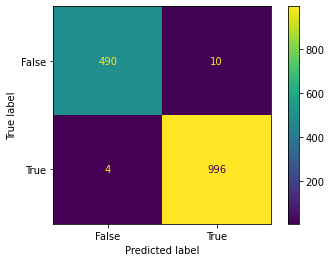

In [397]:
mat_con = (confusion_matrix(true, pred_value))
metrics.ConfusionMatrixDisplay(confusion_matrix = mat_con, display_labels = [False, True]).plot()

Grâce aux différentes mesures et à la matrice de confusion on pourra comparer nos deux modèles.

## K-means

Pour notre validation croisée on commence par faire notre mesure de silouhette pour connaitre le nombre de clusters idéals.

In [398]:
X = billets.values

std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

[0.42003233065954815, 0.24190949640343465, 0.22801990440425926, 0.15825475631006625, 0.14313668615087108, 0.15194455757803335, 0.20462867354217593, 0.1438238294524003]


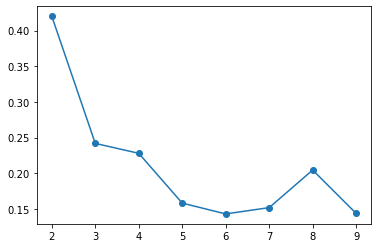

In [399]:
silhouettes = []

for num_clusters in range(2, 10):
  cls = cluster.KMeans(n_clusters=num_clusters, n_init=1, init='random')
  cls.fit(X_scaled)
  silh = metrics.silhouette_score(X_scaled, cls.labels_)
  silhouettes.append(silh)

print(silhouettes)
plt.plot(range(2,10), silhouettes, marker="o")

Le nombre de cluster est logiquement de 2. On effectue la validation croisée.

In [400]:
billets2 = billets.drop('is_genuine', axis=1)

true = []
pred = []
folds = KFold(n_splits=5, shuffle=True, random_state=1).split(billets2)
for train, test in folds:
    X = billets2.iloc[train]
    kmeans = cluster.KMeans(n_clusters=2, random_state=2).fit(X)
    pred.append(kmeans.predict(billets2.iloc[test]))
    true.append(billets.iloc[test]['is_genuine'])
true = np.concatenate(true)
pred = np.concatenate(pred)

### Évaluation du modèle

Puis on évalue le modèle.

In [401]:
accuracy_score(true, pred, normalize = True , sample_weight = None)

0.9846666666666667

In [402]:
precision_score(true, pred, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

0.9793915603532876

In [403]:
recall_score(true, pred, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

0.998

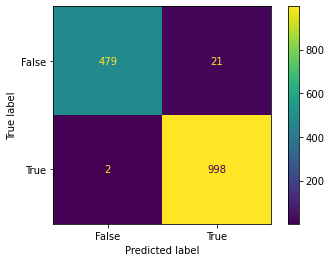

In [404]:
mat_con = (confusion_matrix(true, pred))
metrics.ConfusionMatrixDisplay(confusion_matrix = mat_con, display_labels = [False, True]).plot()

## Choix de l'algorythme

Grâce aux différentes mesure on peut voir que la regression logistique est plus efficace car le precision score et l'accuracy score sont supérieurs et on peut aussi voir que malgrès un nombre de faux positif plus bas le modèle k-means à beaucoup plus de vrai négatif. Il classe donc beaucoup plus de faux billets dans la catégorie vrais billets.

On va donc choisir le modèle de régression logistique.

# Algorithme de détéction

Pour finir nous allons créer un algorithme qui va nous permettre de définir si un billet est un vrai ou un faux grâce au modèle de regression logistique.

In [405]:
reg_log = smf.glm('is_genuine ~ margin_low+diagonal+height_left+height_right+margin_up+length', data=billets, family=sm.families.Binomial()).fit()

reg_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Generalized Linear Model Regression Results                             
=====================================================================================================
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1500
Model:                                                   GLM   Df Residuals:                     1493
Model Family:                                       Binomial   Df Model:                            6
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -39.524
Date:                                       Sat, 18 Mar 2023   Deviance:                       79.048
Time:                                               15:41:07   Pearson chi2:                 2.81e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7049
Covariance Type:                                   nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      230.4143    249.954      0.922      0.357    -259.486     720.315
margin_low       6.0235      0.988      6.099      0.000       4.088       7.959
diagonal        -0.2562      1.135     -0.226      0.821      -2.481       1.969
height_left      1.2845      1.117      1.150      0.250      -0.905       3.474
height_right     2.8941      1.143      2.533      0.011       0.654       5.134
margin_up       10.2986      2.206      4.669      0.000       5.975      14.622
length          -6.0561      0.897     -6.751      0.000      -7.814      -4.298
================================================================================
"""

Pour cela on crée une fonction qui prend en paramètre le chemin d'un fichier à tester.

In [406]:
def is_genuine(path):
    billets_prod = pd.read_csv(path)
    billets_prod['proba_rate'] = reg_log.predict(billets_prod)
    for id in range(len(billets_prod)):
        if billets_prod.loc[id, 'proba_rate'] <= 0.5:
            billets_prod.loc[id, 'is_genuine'] = True
        else:
            billets_prod.loc[id, 'is_genuine'] = False

    return billets_prod

is_genuine('./billets_test.csv')

,diagonal,height_left,height_right,margin_low,margin_up,length,id,proba_rate,is_genuine
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,0.000763,True
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,0.999784,False
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,0.000031,True
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,1.000000,False
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,0.998790,False
